In [1]:
import sys
import os

sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import (
    RandomIntervalSDOMLDataset,
    RandomIntervalSDOMLDataModule,
)
from sdofm.datasets.BrightSpotsSDOML import (
    BrightSpotsSDOMLDataset,
    BrightSpotsSDOMLDataModule,
)
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch

In [2]:
from importlib import reload
from sdofm.models import unet

reload(unet)

channel_to_predict = 6
model = unet.UNet(
    n_channels=12,
    n_classes=1,
    bilinear=False,
    use_embeddings_block=False,
    size_factor=4,
)
psize = [np.prod(i.shape) for i in model.parameters()]
print("model total parameters    ", sum(psize))

model total parameters     2229650


In [3]:
x = torch.rand(4, 12, 512, 512)
model(x).shape

torch.Size([4, 1, 512, 512])

In [4]:
def train_loop(model, dataloader, optimizer, num_epochs=100):
    lossh, lossvalh = [], []
    predictions, targets = [], []

    try:

        for epoch in range(num_epochs):
            t0 = datetime.now()

            for step, batch in enumerate(dataloader):
                # extract data from batch
                image_stack = batch["image_stack"].cuda()
                bright_spots = batch["bright_spots"].cuda()
                # run model
                pred = model(image_stack)

                # compute loss
                loss = loss_fn(bright_spots, pred)

                # backpropagate and update weights
                loss.backward()
                optimizer.step()

                lossvaln = 0.0
                # cosmetics
                lossn = loss.detach().cpu().numpy()
                lossh.append(lossn)

                lossvalh.append(lossvaln)

                psummary = np.mean(
                    [
                        (p.abs().mean().detach().cpu().numpy())
                        for p in model.parameters()
                    ]
                )
                lossm = np.mean(lossh[-100:])
                lossvalm = np.mean(lossvalh[-100:])
                epoch_time = (datetime.now() - t0).seconds

                checksum = {
                    k: float(f"{v:3f}") for k, v in model.param_checksum().items()
                }

                print(
                    f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs {checksum}",
                    end="\r",
                )
            print()
    except KeyboardInterrupt:
        print("\nkeyboard interrupt")

    return lossh

In [5]:
def ploth(h, name="loss", ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f"smoothed {name}"] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=0.5, ax=ax)
    plt.grid()
    plt.xlabel("steps")
    plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)

In [6]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [7]:
data_module = BrightSpotsSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=4,
    num_workers=14,
    blosc_cache="/home/rlx/blosc_cache",
    start_date="2011-01-01",
    end_date="2011-12-31",
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


## instantiate model (encoder + time delta predictor) 

In [8]:
from sdofm.models import unet

reload(unet)
channel_to_predict = 6
model = unet.UNet(
    n_channels=12, n_classes=1, bilinear=True, use_embeddings_block=True, size_factor=4
)
psize = [np.prod(i.shape) for i in model.parameters()]
print("model total parameters    ", sum(psize))

model total parameters     1571378


In [56]:
self = model
model_name = f"unetmodel_{self.n_channels}ch_{self.n_classes}classes_{'bilinear' if self.bilinear else 'notbilinear'}_sizefactor{self.size_factor}"
model_name

'unetmodel_12ch_1classes_bilinear_sizefactor4'

## send models to cuda and init optimizer

In [9]:
model = model.cuda()

optimizer_unet = torch.optim.Adam(model.encoder_decoder_layers.parameters(), lr=1e-3)
optimizer_embeddings = torch.optim.Adam(
    model.embeddings_decoder_layers.parameters(), lr=1e-5
)

loss_fn = lambda a, b: torch.sqrt(torch.mean((a - b) ** 2))
# loss_fn = lambda a,b: torch.mean((a-b)**2 )

In [10]:
model.param_checksum()

{'encoder': 764.668212890625,
 'embeddings': -26.57575798034668,
 'decoder': 271.5400390625}

# train encoder - decoder, bypass embeddings

dataloader len 7211
epoch   0 step 747 loss 0.03941 lossval 0.00000 params 0.9031779 epoch_time 140 secs {'encoder': -29747.214844, 'embeddings': -26.575758, 'decoder': -16343.259766}
keyboard interrupt


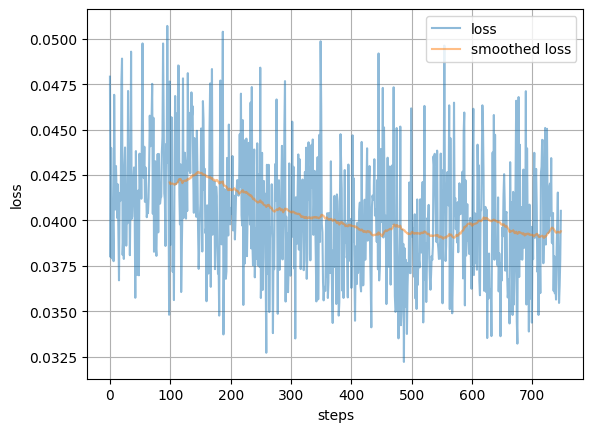

In [16]:
model.use_embeddings_block = False
dataloader = data_module.train_dataloader()
print("dataloader len", len(dataloader))
lossh = train_loop(model, dataloader, optimizer_unet)
ploth(lossh)

# train embeddings + decoder, freeze encoder

dataloader len 7211
epoch   0 step 7210 loss 0.03902 lossval 0.00000 params 0.9595370 epoch_time 1380 secs {'encoder': -29774.904297, 'embeddings': -19080.990234, 'decoder': -18811.730469}
epoch   1 step 7210 loss 0.03847 lossval 0.00000 params 0.9817601 epoch_time 1380 secs {'encoder': -29774.904297, 'embeddings': -28628.46875, 'decoder': -19766.248047}}
epoch   2 step 7210 loss 0.03823 lossval 0.00000 params 1.0048609 epoch_time 1385 secs {'encoder': -29774.904297, 'embeddings': -37772.519531, 'decoder': -20763.285156}
epoch   3 step 7210 loss 0.03792 lossval 0.00000 params 1.0279905 epoch_time 1386 secs {'encoder': -29774.904297, 'embeddings': -48462.539062, 'decoder': -21842.132812}
epoch   4 step 7210 loss 0.03740 lossval 0.00000 params 1.0512458 epoch_time 1386 secs {'encoder': -29774.904297, 'embeddings': -58599.835938, 'decoder': -22913.617188}
epoch   5 step 7210 loss 0.03707 lossval 0.00000 params 1.0748631 epoch_time 1382 secs {'encoder': -29774.904297, 'embeddings': -69124.

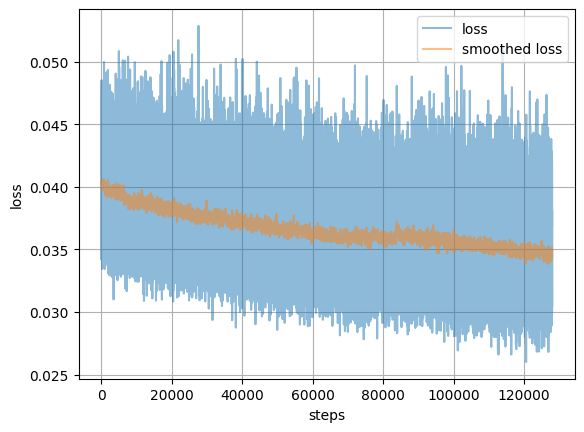

In [37]:
model.use_embeddings_block = True
dataloader = data_module.train_dataloader()
print("dataloader len", len(dataloader))
lossh = train_loop(model, dataloader, optimizer_embeddings)
ploth(lossh)

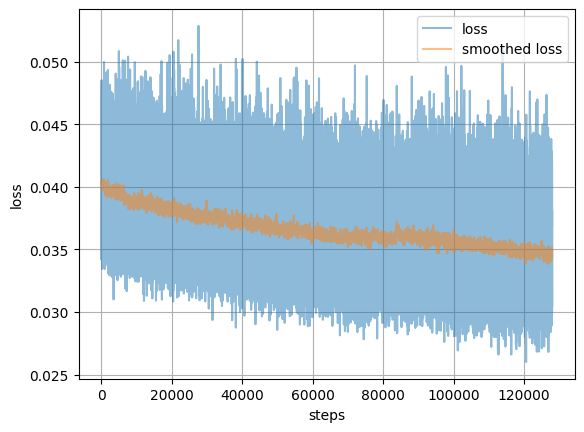

In [38]:
ploth(lossh)

In [57]:
torch.save(model, f"{model_name}.ckpt")

22791.524853229523

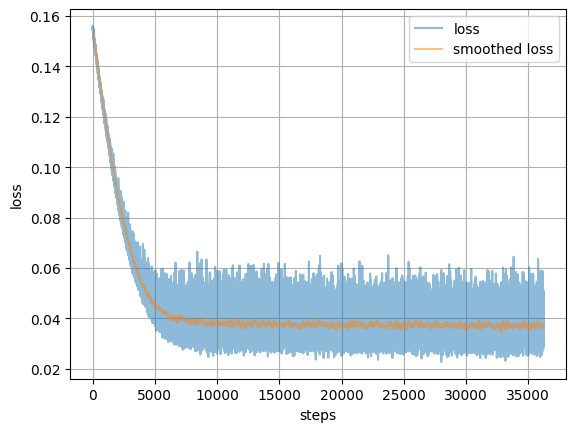

In [26]:
ploth(lossh)
sum(list(et.elapsed_times.values()))

In [11]:
1

1

In [41]:
valdl = data_module.train_dataloader()
val_iter = iter(valdl)

In [42]:
for _ in range(2):
    batch = next(val_iter)

image_stack = batch["image_stack"].cuda()
bright_spots = batch["bright_spots"].cuda()
pred = model(image_stack)
image_stack.sum()

tensor(-1150736.1250, device='cuda:0')

In [47]:
x = model.forward_encode(image_stack)
emb = model.forward_to_embeddings(x)
emb.shape

torch.Size([4, 512])

In [43]:
image_stack.sum()

tensor(-1150736.1250, device='cuda:0')

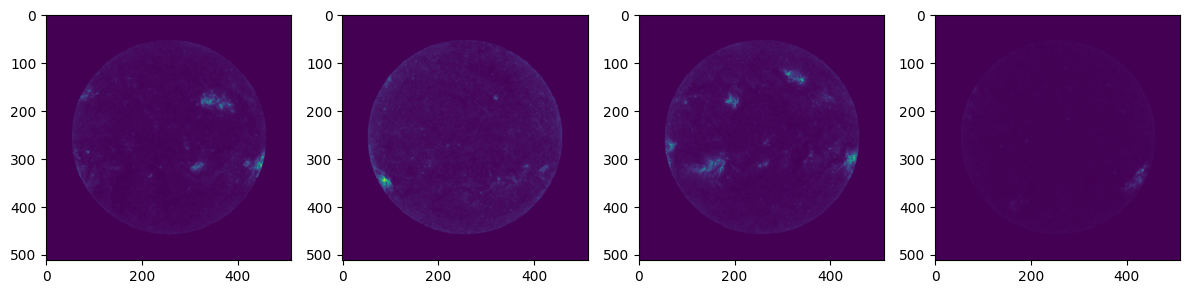

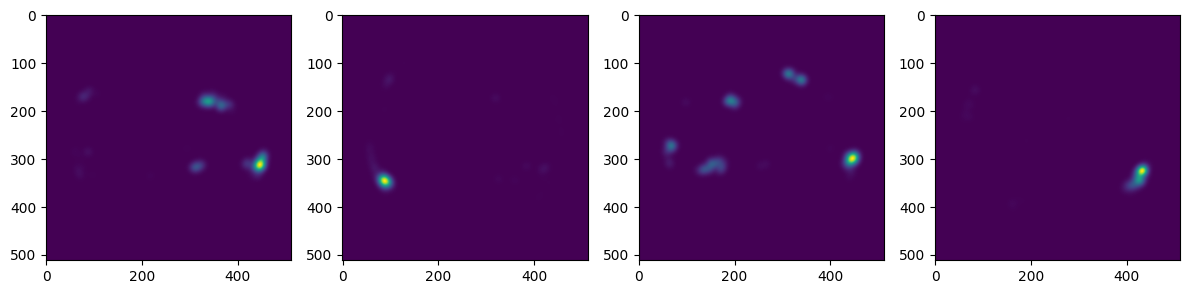

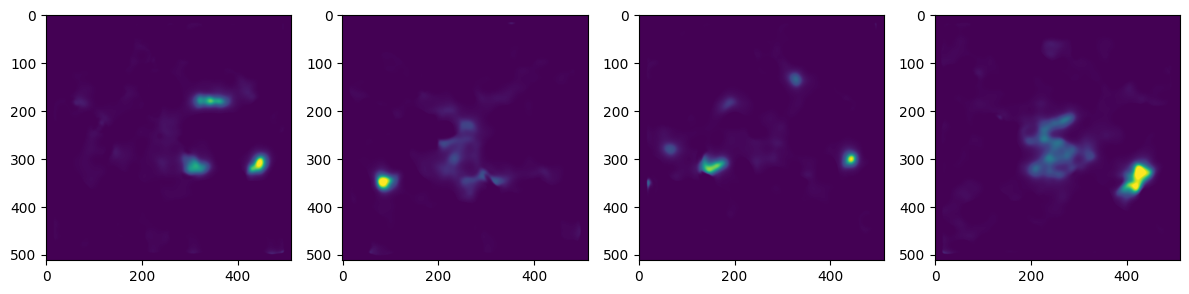

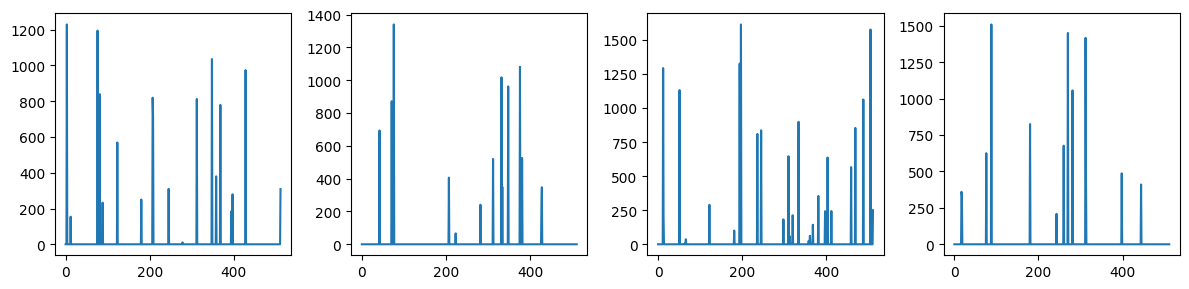

In [52]:
for ax, i in subplots(len(pred)):
    x = image_stack[i, 0].detach().cpu().numpy()
    # a,b = np.percentile(x, (1,99))
    # plt.imshow(x, vmin=a, vmax=b)
    plt.imshow(x)

for ax, i in subplots(len(pred)):
    x = bright_spots[i, 0].detach().cpu().numpy()
    plt.imshow(x)

for ax, i in subplots(len(pred)):
    x = pred[i, 0].detach().cpu().numpy()
    plt.imshow(x)

for ax, i in subplots(len(emb)):
    x = emb[i].detach().cpu().numpy()
    plt.plot(x)

In [59]:
x = image_stack
self = model
x = self.inc(x)
x = self.down1(x)
x = self.down2(x)
x.shape

torch.Size([4, 64, 128, 128])

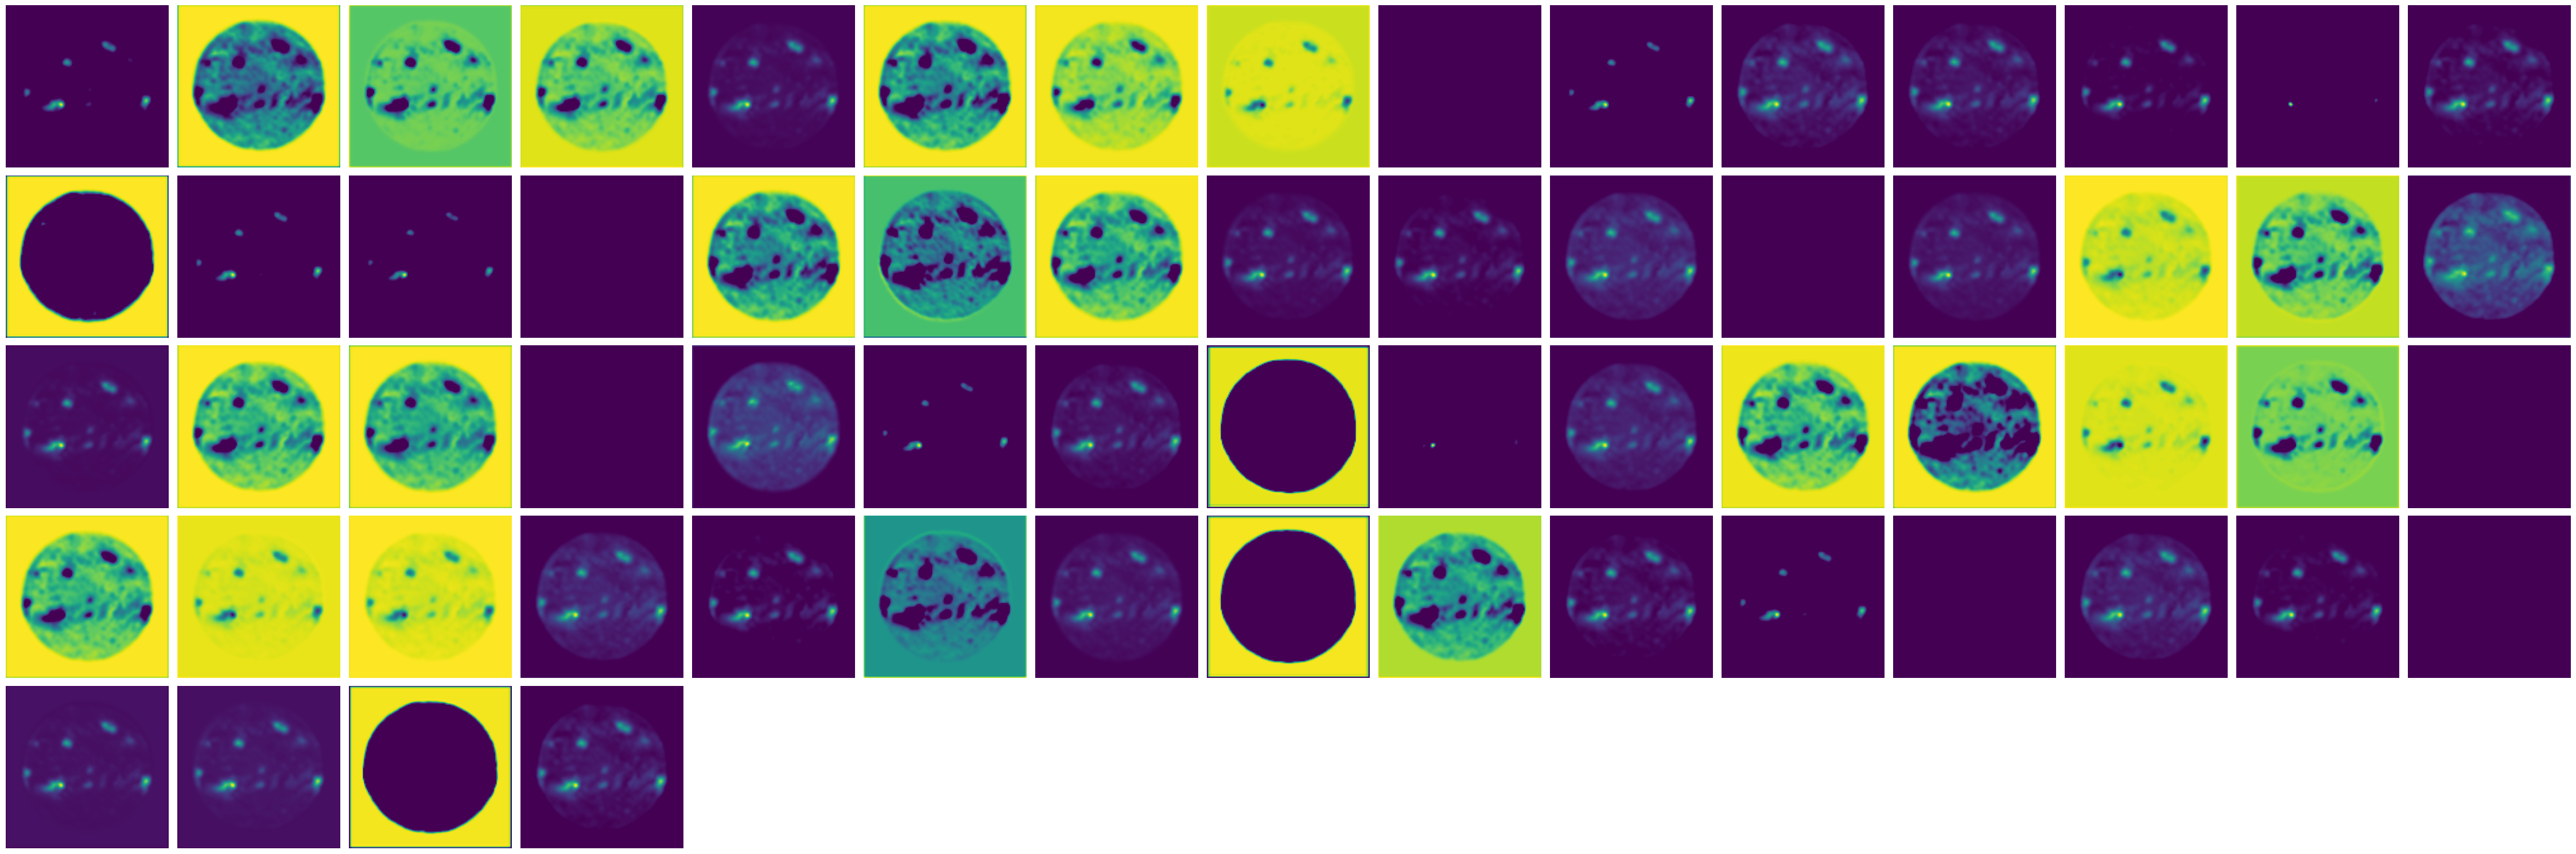

In [60]:
for ax, i in subplots(x.shape[1]):
    plt.imshow(x[2, i].cpu().detach().numpy())
    plt.axis("off")

In [61]:
e = model.forward_encode(image_stack)
e.shape

torch.Size([4, 128, 32, 32])

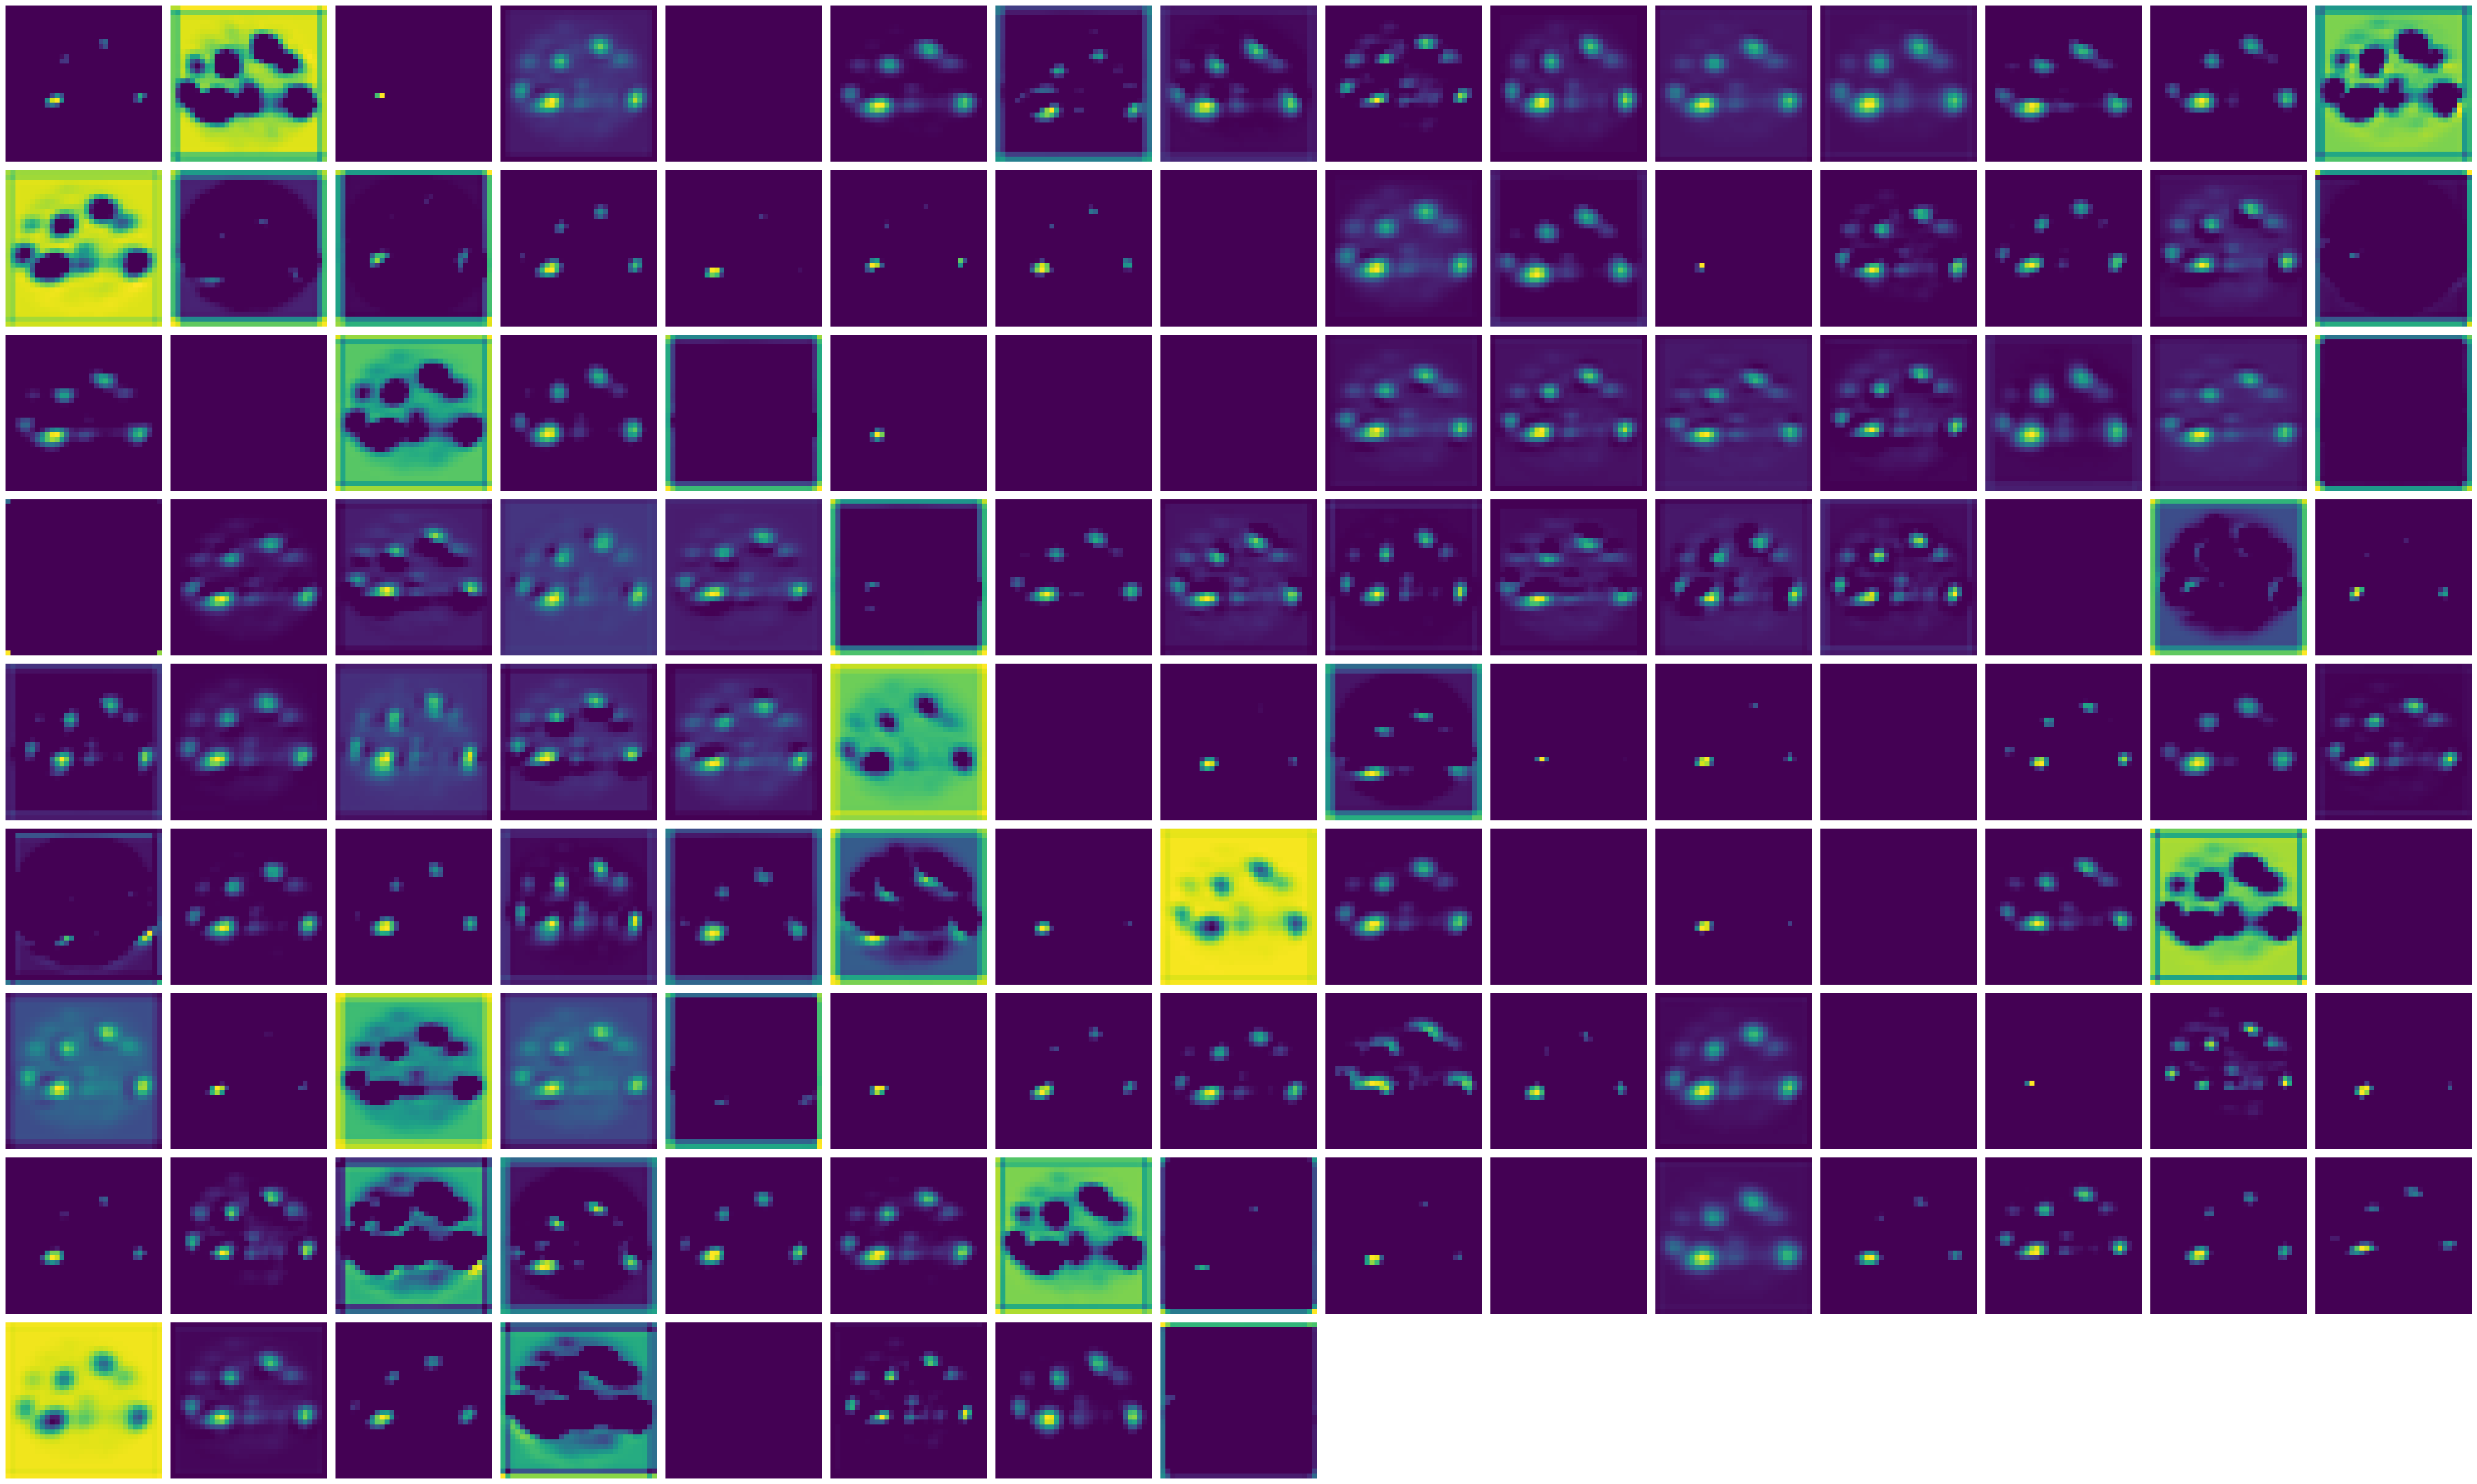

In [62]:
for ax, i in subplots(e.shape[1]):
    plt.imshow(e[2, i].cpu().detach().numpy())
    plt.axis("off")

In [44]:
from torch import nn
import torch.nn.functional as F

In [43]:
F.fla

NameError: name 'F' is not defined

In [12]:
x = model.forward_encode(image_stack)
x.shape

torch.Size([4, 512, 32, 32])

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
flatten = nn.Flatten()
conv1x1 = nn.Conv2d(512, 1, 1)
conv512 = nn.Conv2d(1, 512, 1)
fc1 = nn.Linear(1024, 512)
fc2 = nn.Linear(512, 512)

fc3 = nn.Linear(512, 1024)

In [21]:
x = model.forward_encode(image_stack).cpu()
x = conv1x1(x)
x = flatten(x)
x = F.sigmoid(fc1(x))
x = F.sigmoid(fc2(x))
x = F.sigmoid(fc3(x))
x = x.reshape(-1, 1, 32, 32)
x = F.sigmoid(conv512(x))
x.shape

torch.Size([4, 512, 32, 32])

In [22]:
x = model.forward_decode(x.cuda())

In [23]:
x.shape

torch.Size([4, 64, 512, 512])

In [10]:
image_stack = b["image_stack"]
bright_spots = b["bright_spots"]

In [11]:
image_stack.shape, bright_spots.shape

(torch.Size([4, 12, 512, 512]), torch.Size([4, 12, 512, 512]))

In [8]:
from importlib import reload

In [49]:
from sdofm.models import unet

reload(unet)

m = unet.UNet(n_channels=12, n_classes=1, bilinear=True)

In [40]:
x = torch.tensor(image_stack).reshape(1, *image_stack.shape)
t = 
x.shape, type(x)

(torch.Size([1, 12, 512, 512]), torch.Tensor)

In [54]:
x = b["image_stack"]
o = m(x)[:, 0]
o.shape

torch.Size([4, 512, 512])

In [43]:
channel_to_predict = 6

In [53]:
bright_spots[:, channel_to_predict].shape

torch.Size([4, 512, 512])

In [13]:
image_stack = b["image_stack"]
bright_spots = b["bright_spots"]

In [15]:
preds = model(image_stack.cuda())

In [18]:
preds[:, 0].shape, bright_spots[:, 6].shape

(torch.Size([4, 512, 512]), torch.Size([4, 512, 512]))

In [20]:
loss_fn(preds[:, 0], bright_spots[:, 6].cuda())

tensor(0.4839, device='cuda:0', grad_fn=<SqrtBackward0>)